In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as randomForestRegressor
from scipy.integrate import simps
from xgboost import XGBRegressor


In [3]:
df = pd.read_csv(r"C:/Users/Acer/Desktop/study 4 sem/ML/project/datasets/Australian Vehicle Prices.csv", index_col=False)
print("DF Size:" ,df.shape)
df.head(5)

DF Size: (16734, 19)


,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [4]:
#Brand: Name of the car manufacturer
#Year: Year of manufacture or release
#Model: Name or code of the car model
#Car/Suv: Type of the car (car or suv)
#Title: Title or description of the car
#UsedOrNew: Condition of the car (used or new)
#Transmission: Type of transmission (manual or automatic)
#Engine: Engine capacity or power (in litres or kilowatts)
#DriveType: Type of drive (front-wheel, rear-wheel, or all-wheel)
#FuelType: Type of fuel (petrol, diesel, hybrid, or electric)
#FuelConsumption: Fuel consumption rate (in litres per 100 km)
#Kilometres: Distance travelled by the car (in kilometres)
#ColourExtInt: Colour of the car (exterior and interior)
#Location: Location of the car (city and state)
#CylindersinEngine: Number of cylinders in the engine
#BodyType: Shape or style of the car body (sedan, hatchback, coupe, etc.)
#Doors: Number of doors in the car
#Seats: Number of seats in the car
#Price: Price of the car (in Australian dollars)

In [5]:
df.iloc[0]
df.nunique()
df['Price'].unique()
if 0 in df['Price'].unique():
    print("YES")
else:
    print("NO")

NO


In [6]:
df = df[pd.to_numeric(df['Kilometres'], errors='coerce').notna()]
df["Kilometres"] = df["Kilometres"].astype("float")
df = df[pd.to_numeric(df['Kilometres'], errors='coerce').notna()]
df["Kilometres"] = df["Kilometres"].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16142 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16142 non-null  object 
 1   Year               16142 non-null  float64
 2   Model              16142 non-null  object 
 3   Car/Suv            16139 non-null  object 
 4   Title              16142 non-null  object 
 5   UsedOrNew          16142 non-null  object 
 6   Transmission       16142 non-null  object 
 7   Engine             16142 non-null  object 
 8   DriveType          16142 non-null  object 
 9   FuelType           16142 non-null  object 
 10  FuelConsumption    16142 non-null  object 
 11  Kilometres         16142 non-null  float64
 12  ColourExtInt       16142 non-null  object 
 13  Location           16142 non-null  object 
 14  CylindersinEngine  16142 non-null  object 
 15  BodyType           15873 non-null  object 
 16  Doors              145

In [7]:
def featureEngine(x):
    x.replace('None', np.nan, inplace=True)
    x.replace('-', np.nan, inplace=True)
    x.replace('nan', np.nan, inplace=True)
    
    x.dropna(subset=['Year'], inplace=True)
    x.dropna(subset=['Price'], inplace=True)
    x.drop(['Title'], axis = 1, inplace = True) 
    
    x['Brand & Model'] = x['Brand'].astype(str) + " " + x['Model'].astype(str)
    x.drop(['Brand'], axis = 1, inplace = True)
    x.drop(['Model'], axis = 1, inplace = True)
    
    x.drop(['Car/Suv'], axis = 1, inplace = True)
    
    x['Year'] = x['Year'].astype('float')
    
    x[['EngineCLY','EngineL']] = x['Engine'].astype(str).str.split(", ",expand = True)
    x['Engine'] = x['EngineL']
    x['Engine'] = x['Engine'].astype(str).str.replace(' L', "")
    x.drop(['EngineCLY'], axis = 1, inplace = True) 
    x.drop(['EngineL'], axis = 1, inplace = True)
    x.rename(columns={'Engine': 'EngineL'}, inplace=True)
    x['EngineL'].replace('None', 0, inplace=True)
    x['EngineL'] = x['EngineL'].astype('float')
    
    x[['FuelC','KM']] = x['FuelConsumption'].astype(str).str.split(" / ",expand = True)
    x['FuelConsumption'] = x['FuelC']
    x['FuelConsumption'] = x['FuelConsumption'].astype(str).str.replace(' L', "")
    x.drop(['KM'], axis = 1, inplace = True)
    x.drop(['FuelC'], axis = 1, inplace = True)
    x['FuelConsumption'].replace('nan', 0, inplace=True)
    x['FuelConsumption'] = x['FuelConsumption'].astype('float')
    
    x['Kilometres'] = x['Kilometres']
    
    ll=[]
    for i in x['ColourExtInt']:
        xv=''
        for j in str(i):
            if j=='/':
                pass
            else:
                xv=xv+j
        ll.append(xv)
        xv=''
    x['ColourExtInt']=ll
    x.rename(columns={'ColourExtInt': 'Color'}, inplace=True)
    x['Color'] = x['Color'].astype(str).str.replace(' -', "")
    
    x[['City','District']] = x['Location'].astype(str).str.split(", ",expand = True)
    x['District'].replace({None: np.nan}, inplace=True)
    x.drop(['Location'], axis = 1, inplace = True)
    
    x['CylindersinEngine'] = x['CylindersinEngine'].fillna(0).astype(str)
    x['CylindersinEngine'] = x['CylindersinEngine'].astype(str).str.extract('(\d+)').astype('float32')
    x['CylindersinEngine'] = x['CylindersinEngine'].fillna(0).astype('float')
    
    x['Doors'] = x['Doors'].fillna(0).astype(str)
    x['Doors'] = x['Doors'].astype(str).str.extract('(\d+)').astype('float')
    
    x['Seats'] = x['Seats'].fillna(0).astype(str)
    x['Seats'] = x['Seats'].astype(str).str.extract('(\d+)').astype(float)
    
    x['Price'] = x['Price']
    
    x.replace('None', np.nan, inplace=True)
    x.replace('-', np.nan, inplace=True)
    x.replace('nan', np.nan, inplace=True)


In [8]:
data = df.copy()
featureEngine(data)
new_order = ['Brand & Model',
             'Year',
             'BodyType',
             'UsedOrNew',
             'Transmission',
             'EngineL',
             'DriveType',
             'FuelType',
             'FuelConsumption',
             'Kilometres',
             'Color',
             'CylindersinEngine',
             'Doors', 
             'Seats',
             'District',
             'City',
             'Price']  
data = data.reindex(columns=new_order)
data.head(5)

,Brand & Model,Year,BodyType,UsedOrNew,Transmission,EngineL,DriveType,FuelType,FuelConsumption,Kilometres,Color,CylindersinEngine,Doors,Seats,District,City,Price
0,Ssangyong Rexton,2022.0,SUV,DEMO,Automatic,2.2,AWD,Diesel,8.7,5595.0,White Black,4.0,4.0,7.0,NSW,Caringbah,51990
1,MG MG3,2022.0,Hatchback,USED,Automatic,1.5,Front,Premium,6.7,16.0,Black Black,4.0,5.0,5.0,NSW,Brookvale,19990
2,BMW 430I,2022.0,Coupe,USED,Automatic,2.0,Rear,Premium,6.6,8472.0,Grey White,4.0,2.0,4.0,NSW,Sylvania,108988
3,Mercedes-Benz E500,2011.0,Coupe,USED,Automatic,5.5,Rear,Premium,11.0,136517.0,White Brown,8.0,2.0,4.0,NSW,Mount Druitt,32990
4,Renault Arkana,2022.0,SUV,USED,Automatic,1.3,Front,Unleaded,6.0,1035.0,Grey Black,4.0,4.0,5.0,NSW,Castle Hill,34990


In [9]:
#data['CylindersinEngine'].nunique()

In [10]:
df.nunique()
data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16140 entries, 0 to 16733
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand & Model      16140 non-null  object 
 1   Year               16140 non-null  float64
 2   BodyType           15871 non-null  object 
 3   UsedOrNew          16140 non-null  object 
 4   Transmission       15923 non-null  object 
 5   EngineL            16140 non-null  float64
 6   DriveType          16140 non-null  object 
 7   FuelType           15580 non-null  object 
 8   FuelConsumption    16140 non-null  float64
 9   Kilometres         16140 non-null  float64
 10  Color              16140 non-null  object 
 11  CylindersinEngine  16140 non-null  float64
 12  Doors              16140 non-null  float64
 13  Seats              16140 non-null  float64
 14  District           16140 non-null  object 
 15  City               16140 non-null  object 
 16  Price              161

In [11]:
feature_numeric = [cname for cname in data.columns if data[cname].dtype == "float"]
feature_columnas = [cname for cname in data.columns if data[cname].dtype == "object"]
data[feature_columnas] = data[feature_columnas].astype("str")
print(feature_numeric)
print(feature_columnas)

['Year', 'EngineL', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats']
['Brand & Model', 'BodyType', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'Color', 'District', 'City', 'Price']


In [12]:
features_cat = ['Brand & Model', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'Color', 'BodyType', 'District', 'City']
features_num = [['Year', 'EngineL', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats', 'Price']]

le = LabelEncoder()
for columna in feature_columnas:
    data[columna] = le.fit_transform(data[columna])

knnimputer = KNNImputer(n_neighbors=5)

for columna in features_num:
    data[columna] = knnimputer.fit_transform(data[columna])

In [13]:
data.isna().sum()
data = data.astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16140 entries, 0 to 16733
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand & Model      16140 non-null  float64
 1   Year               16140 non-null  float64
 2   BodyType           16140 non-null  float64
 3   UsedOrNew          16140 non-null  float64
 4   Transmission       16140 non-null  float64
 5   EngineL            16140 non-null  float64
 6   DriveType          16140 non-null  float64
 7   FuelType           16140 non-null  float64
 8   FuelConsumption    16140 non-null  float64
 9   Kilometres         16140 non-null  float64
 10  Color              16140 non-null  float64
 11  CylindersinEngine  16140 non-null  float64
 12  Doors              16140 non-null  float64
 13  Seats              16140 non-null  float64
 14  District           16140 non-null  float64
 15  City               16140 non-null  float64
 16  Price              161

<Axes: >

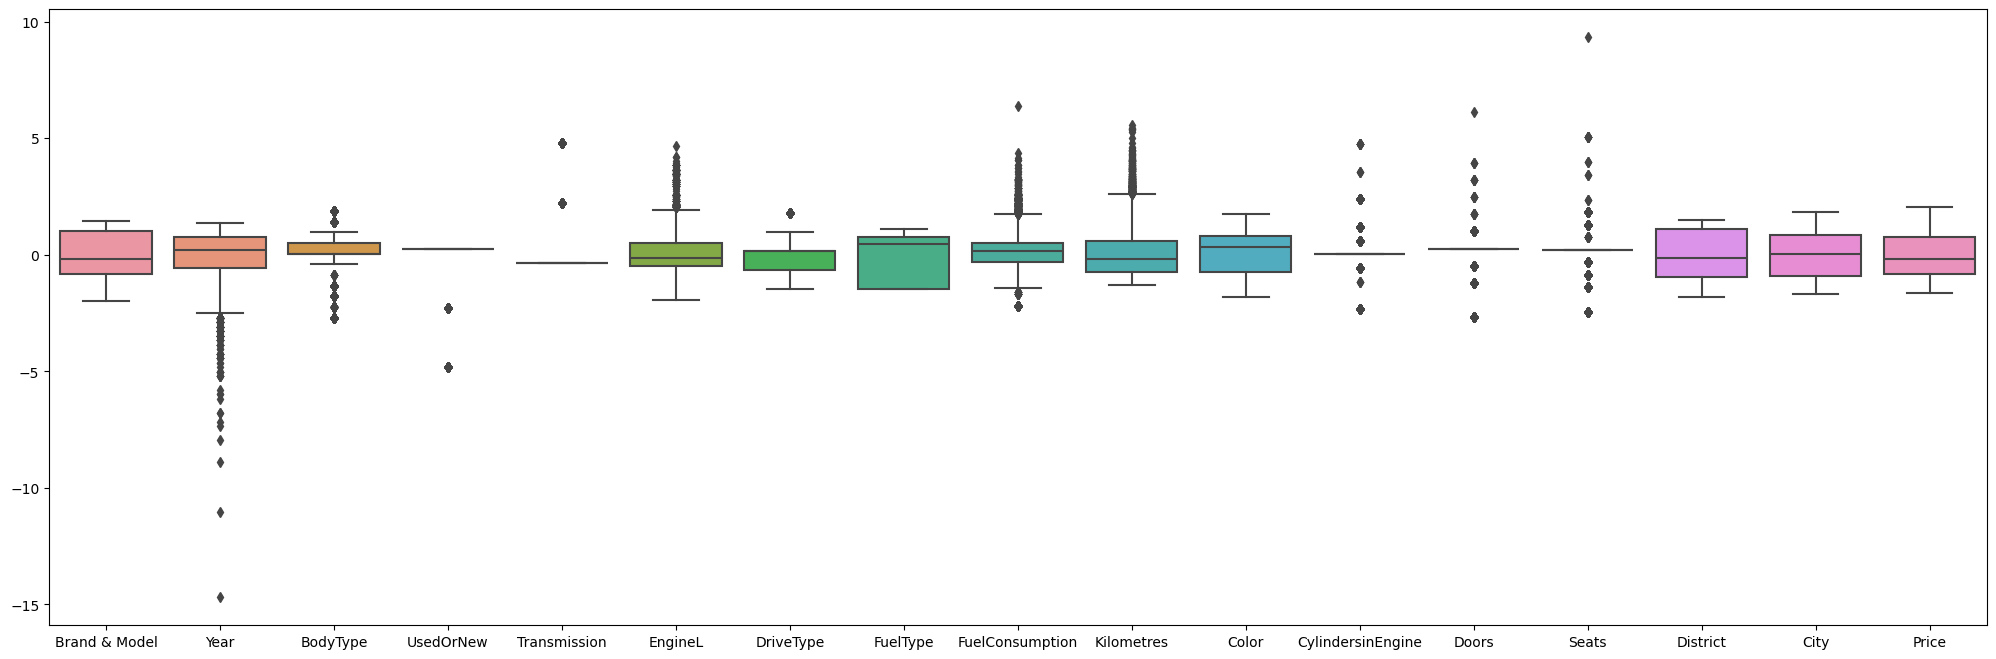

In [14]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

plt.figure(1, figsize=(25, 8))  # Increase the height of the heatmap
sns.boxplot(data_scaled)

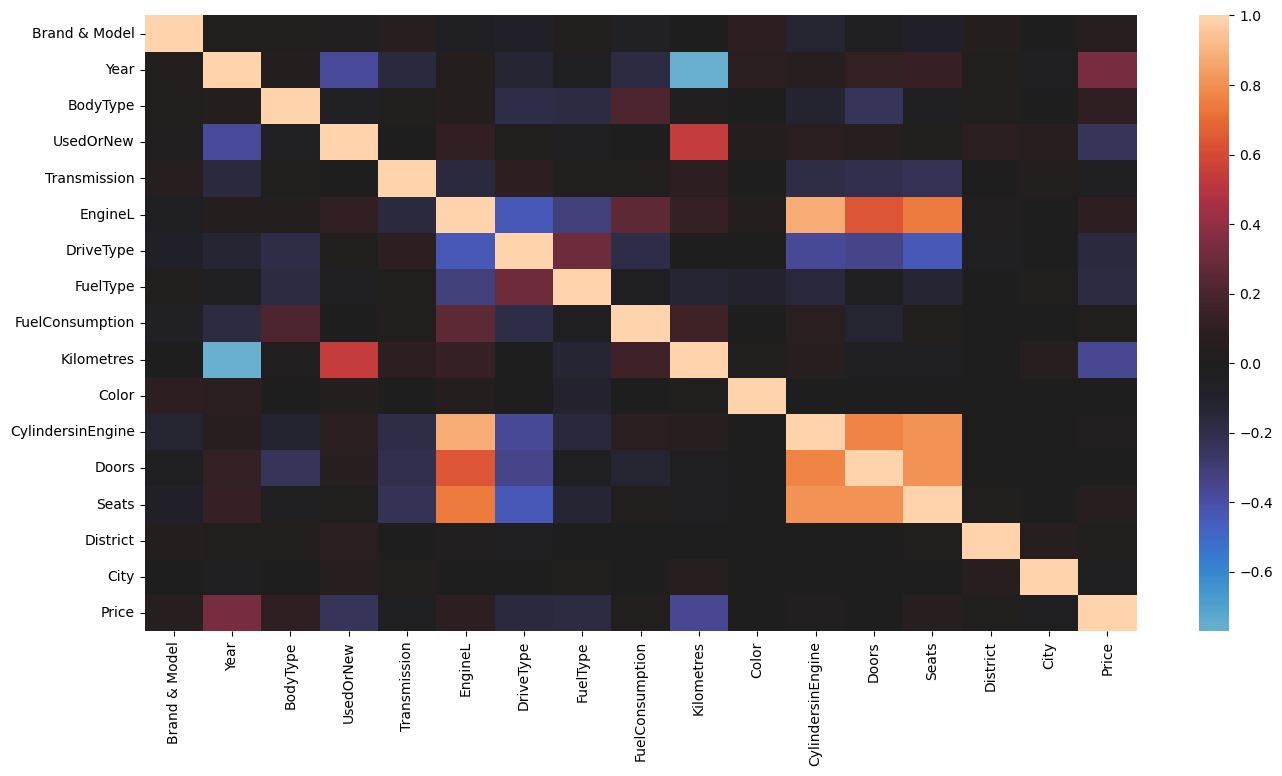

,Brand & Model,Year,BodyType,UsedOrNew,Transmission,EngineL,DriveType,FuelType,FuelConsumption,Kilometres,Color,CylindersinEngine,Doors,Seats,District,City,Price
Brand & Model,1.000000,0.033484,0.036889,0.013258,0.057183,-0.041393,-0.072906,0.028997,-0.057668,-0.003728,0.081867,-0.116321,-0.032306,-0.077726,0.039176,-0.013276,0.049723
Year,0.033484,1.000000,0.042226,-0.380982,-0.160294,0.041085,-0.124470,-0.035171,-0.173933,-0.771112,0.075029,0.048848,0.113279,0.132121,0.031246,-0.036105,0.330082
BodyType,0.036889,0.042226,1.000000,-0.054762,0.021585,0.043114,-0.193119,-0.173209,0.206860,0.014810,-0.005587,-0.111087,-0.237538,-0.019951,0.038047,-0.012092,0.095987
UsedOrNew,0.013258,-0.380982,-0.054762,1.000000,0.009637,0.104402,0.021615,-0.032759,-0.014709,0.543313,0.044619,0.074444,0.046958,0.024446,0.076694,0.052327,-0.231630
Transmission,0.057183,-0.160294,0.021585,0.009637,1.000000,-0.160223,0.084567,0.024093,0.037826,0.093345,-0.003585,-0.186785,-0.205826,-0.230111,0.001364,0.034438,-0.021584
EngineL,-0.041393,0.041085,0.043114,0.104402,-0.160223,1.000000,-0.445101,-0.318612,0.259145,0.120221,0.041539,0.881934,0.639551,0.744104,0.012895,-0.000407,0.091354
DriveType,-0.072906,-0.124470,-0.193119,0.021615,0.084567,-0.445101,1.000000,0.300360,-0.189519,0.009085,0.003933,-0.363702,-0.343843,-0.434340,-0.026644,0.007838,-0.160308
FuelType,0.028997,-0.035171,-0.173209,-0.032759,0.024093,-0.318612,0.300360,1.000000,-0.039227,-0.129071,-0.097579,-0.150348,-0.029489,-0.129546,-0.002929,0.024298,-0.175916
FuelConsumption,-0.057668,-0.173933,0.206860,-0.014709,0.037826,0.259145,-0.189519,-0.039227,1.000000,0.161568,0.010241,0.066101,-0.115250,0.035903,-0.001367,-0.000033,0.036125
Kilometres,-0.003728,-0.771112,0.014810,0.543313,0.093345,0.120221,0.009085,-0.129071,0.161568,1.000000,0.018996,0.053248,-0.034692,-0.023235,0.003409,0.048058,-0.359935


In [30]:
corr = data.corr()
plt.figure(1, figsize=(16, 8))  # Increase the height of the heatmap
sns.heatmap(corr,center=0)  # Reduce the font size of annotations
plt.show()
data.corr()

In [ ]:
corr = data.corr()
plt.figure(1, figsize=(8, 6))  # Increase the height of the heatmap
sns.heatmap(corr,center=0)  # Reduce the font size of annotations
plt.show()
data.corr()

NameError: name 'data' is not defined

Outliers relative to boxplot:
7        2000.0
236      1999.0
273      2002.0
419      1995.0
484      1999.0
          ...  
16388    1989.0
16406    1998.0
16600    1989.0
16607    1940.0
16689    1992.0
Name: Year, Length: 258, dtype: float64


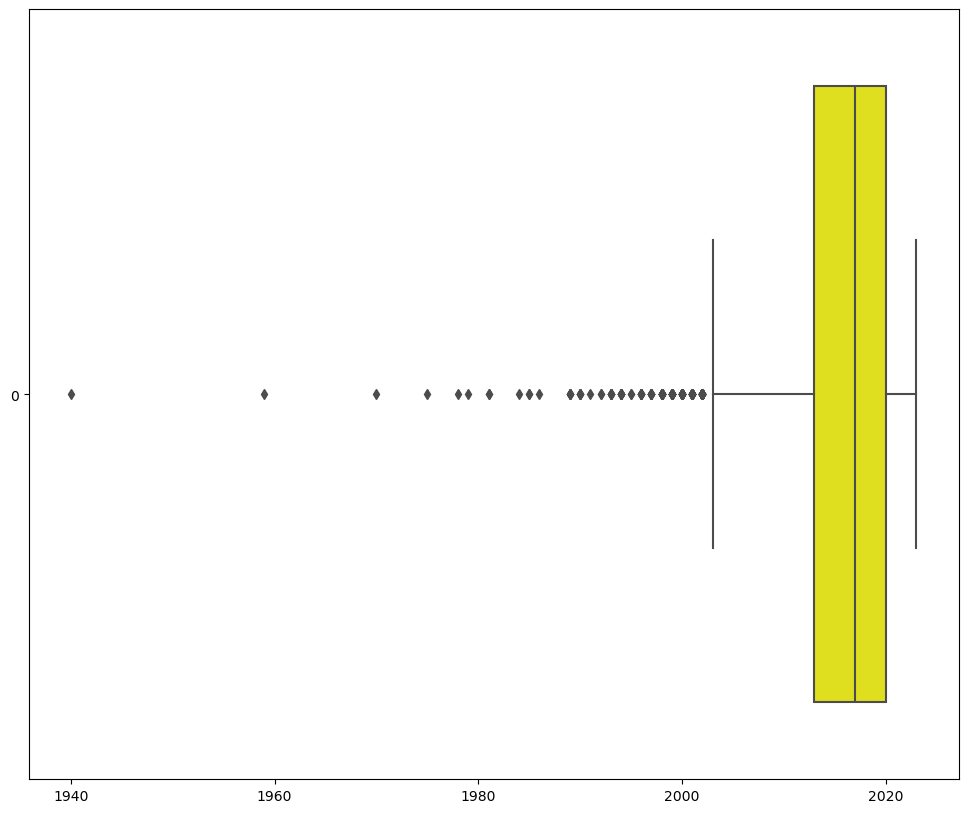

In [16]:
l = "Year"
fig, axs = plt.subplots(1, figsize=(12, 10))
sns.boxplot(data[l],  orient = "h", color = "yellow")


# Calculate quartiles and IQR
Q1 = data[l].quantile(0.75)
Q3 = data[l].quantile(0.25)
IQR = Q3 - Q1

# Define outliers
outliers = data[(data[l] > Q1 - 1.5 * IQR) | (data[l] < Q3 + 1.5 * IQR)]

print("Outliers relative to boxplot:")
print(outliers[l])

<Axes: xlabel='City', ylabel='Count'>

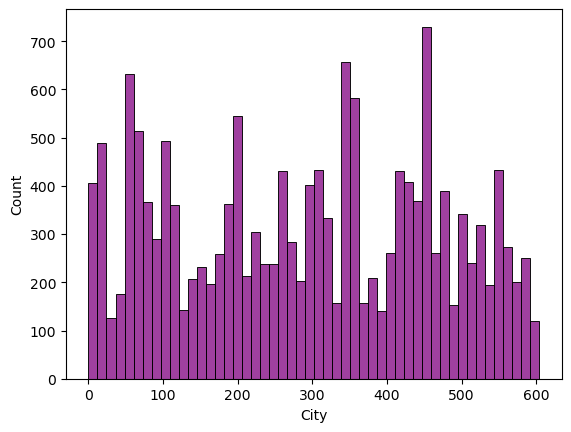

In [17]:
pattern = data[data['Year'] >= 2005]
sns.histplot(data['City'], bins = 50, color = "purple")

In [18]:
data = data[data['Year'] >= 2005]
data = data[data['EngineL'] <= 3]
data = data[data['FuelConsumption'] <= 11]
non_zero_values = data.loc[data['FuelConsumption'] > 0, 'FuelConsumption']

zero_indices = data['FuelConsumption'] == 0
replacement_values = np.random.choice(non_zero_values, size=sum(zero_indices), replace=True)
data.loc[zero_indices, 'FuelConsumption'] = replacement_values

data = data[data['FuelConsumption'] <= 10.6]
data = data[data['FuelConsumption'] >= 4]

data['Kilometres'] = np.sqrt(data['Kilometres'])
data = data[data['Kilometres'] <= 500.0]



<Axes: >

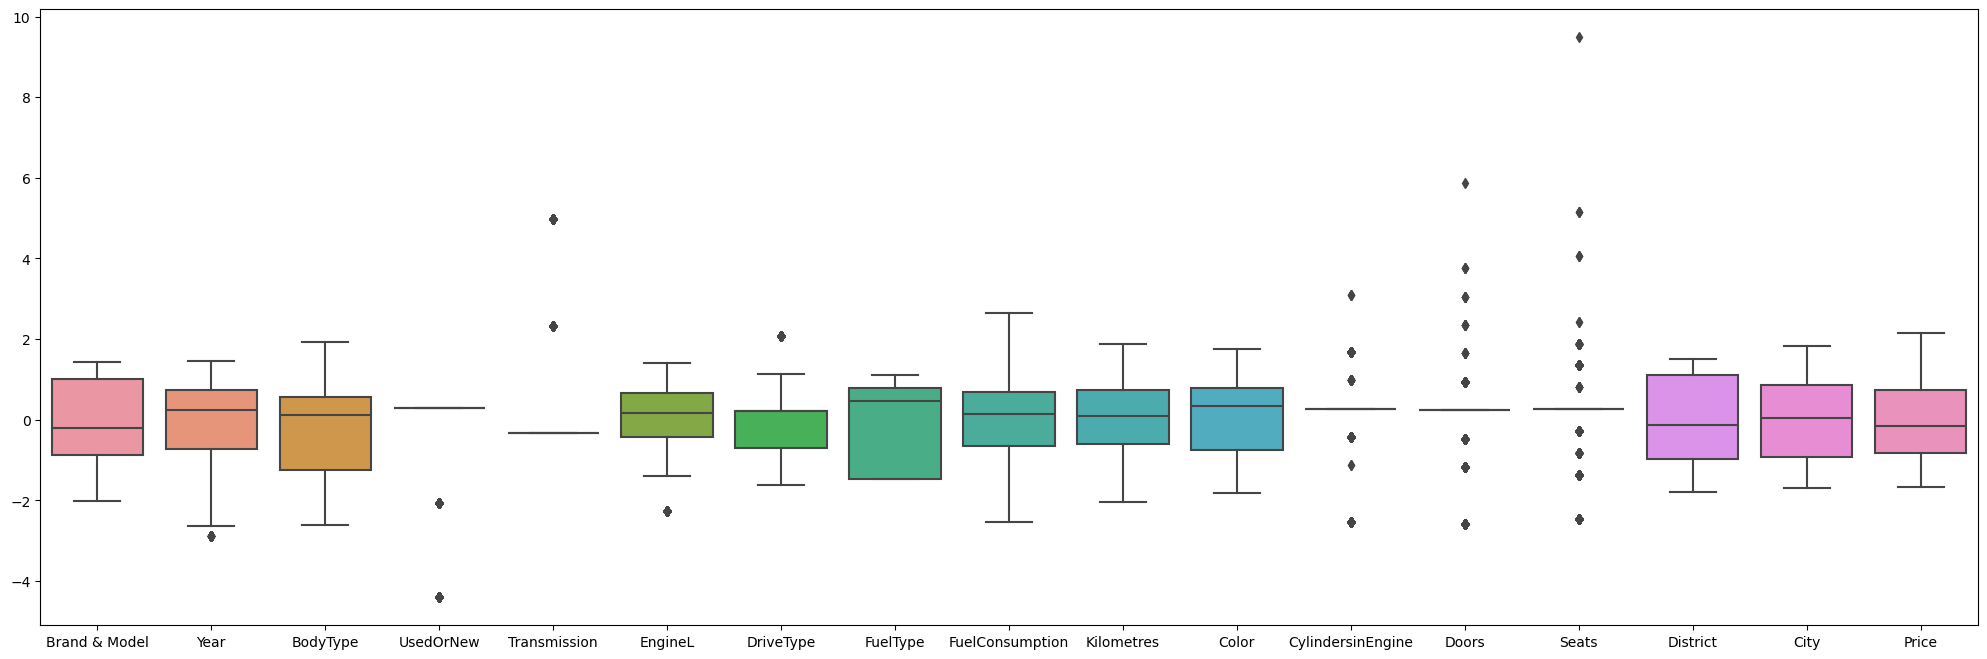

In [19]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

plt.figure(1, figsize=(25, 8))  # Increase the height of the heatmap
sns.boxplot(data_scaled)

In [20]:
X = data.copy()
y = X.pop("Price")
print(X.shape)
print(y.shape)

(12890, 16)
(12890,)


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.34, random_state = 0, shuffle=True)
print(X_valid.shape)
print(y_valid.shape)
print(y_train.shape)
print(X_train.shape)

(4383, 16)
(4383,)
(8507,)
(8507, 16)


In [22]:
X_train = data.sample(frac=0.66, random_state=0)
X_valid = data.drop(X_train.index)
y_train= X_train.pop('Price')
y_valid = X_valid.pop('Price')

In [23]:
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8507 entries, 11329 to 16647
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand & Model      8507 non-null   float64
 1   Year               8507 non-null   float64
 2   BodyType           8507 non-null   float64
 3   UsedOrNew          8507 non-null   float64
 4   Transmission       8507 non-null   float64
 5   EngineL            8507 non-null   float64
 6   DriveType          8507 non-null   float64
 7   FuelType           8507 non-null   float64
 8   FuelConsumption    8507 non-null   float64
 9   Kilometres         8507 non-null   float64
 10  Color              8507 non-null   float64
 11  CylindersinEngine  8507 non-null   float64
 12  Doors              8507 non-null   float64
 13  Seats              8507 non-null   float64
 14  District           8507 non-null   float64
 15  City               8507 non-null   float64
dtypes: float64(16)
memo

In [24]:
print(X_valid.shape)
print(y_valid.shape)
print(y_train.shape)
print(X_train.shape)

(4383, 16)
(4383,)
(8507,)
(8507, 16)


In [25]:
input_shape = [X_train.shape[1]]
input_shape

[16]

Mean Absolute Error: 346.2248902448285
Absolute Difference in AUC: 0.0


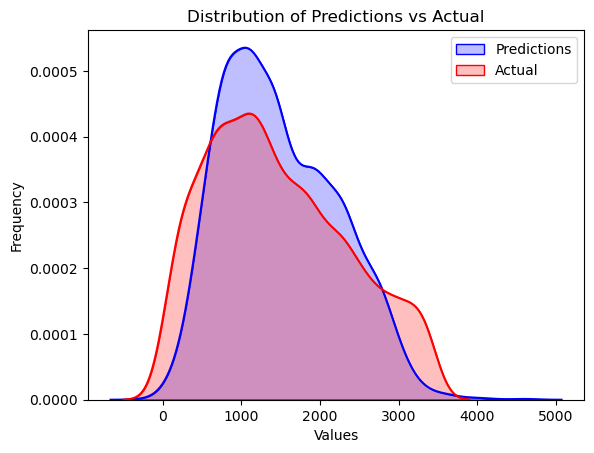

In [26]:
model_2 = XGBRegressor(n_estimators=5000, learning_rate=0.03)

model_2.fit(X_train, y_train,  
             eval_set=[(X_valid, y_valid)],
             verbose = False)

predictions = model_2.predict(X_valid)

# Plot the distribution of predicted and actual values using Kernel Density Plot
sns.kdeplot(predictions, color="blue", label="Predictions", fill=True)
sns.kdeplot(y_valid, color="red", label="Actual", fill=True)

# Set labels and legend
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions vs Actual")
plt.legend()

mae= mean_absolute_error(predictions, y_valid)
print("Mean Absolute Error:", mae)

auc_predictions = simps(sns.kdeplot(predictions, color="blue", label="Predictions").get_lines()[0].get_ydata())
auc_actual = simps(sns.kdeplot(y_valid, color="red", label="Actual").get_lines()[0].get_ydata())

# Calculate the absolute difference in the areas under the curve
area_difference = abs(auc_predictions - auc_actual)
print("Absolute Difference in AUC:", area_difference)

# Show the plot
plt.show()

In [27]:
# Calculate MSE
mse = mean_squared_error(y_valid, predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = mean_absolute_error(y_valid, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate R2 score
r2 = r2_score(y_valid, predictions)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 352808.27856926306
Root Mean Squared Error (RMSE): 593.9766650039908
Mean Absolute Error (MAE): 346.2248902448285
R-squared (R2) Score: 0.547561761881967


In [28]:
model_3=randomForestRegressor() 
model_3.fit(X_train,y_train)
prediction_3=model_3.predict(X_valid)
# Calculate MSE
mse = mean_squared_error(y_valid, prediction_3)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = mean_absolute_error(y_valid, prediction_3)
print("Mean Absolute Error (MAE):", mae)

# Calculate R2 score
r2_score=r2_score(y_valid, prediction_3)
print("R-squared (R2) Score:", r2_score)

Mean Squared Error (MSE): 344212.69461789035
Root Mean Squared Error (RMSE): 586.6964245825011
Mean Absolute Error (MAE): 354.3991634127527
R-squared (R2) Score: 0.5585846632558396
